In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn

from io import BytesIO
import numpy as np
import os
import time
import sys


import util.lr_decay as lrd
import util.misc as misc
from util.datasets import build_dataset
from util.pos_embed import interpolate_pos_embed
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import matplotlib.pyplot as plt

import PIL
from PIL import Image
import requests

import math
inf = math.inf

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

import models_mae

### Utils

In [3]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def load_image(url):
    try:
        response = requests.get(url, stream=True)
        img = Image.open(response.raw)
        img = img.resize((224, 224))
        img = np.array(img) / 255.
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

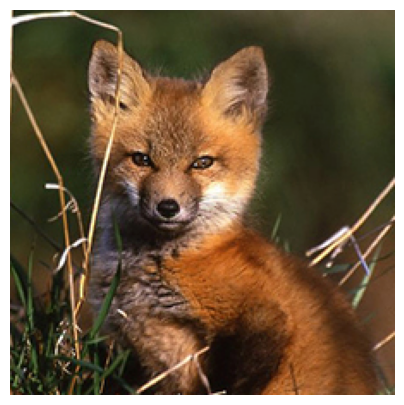

In [4]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))


### Load a pre-trained MAE model

In [5]:
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.



In [6]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


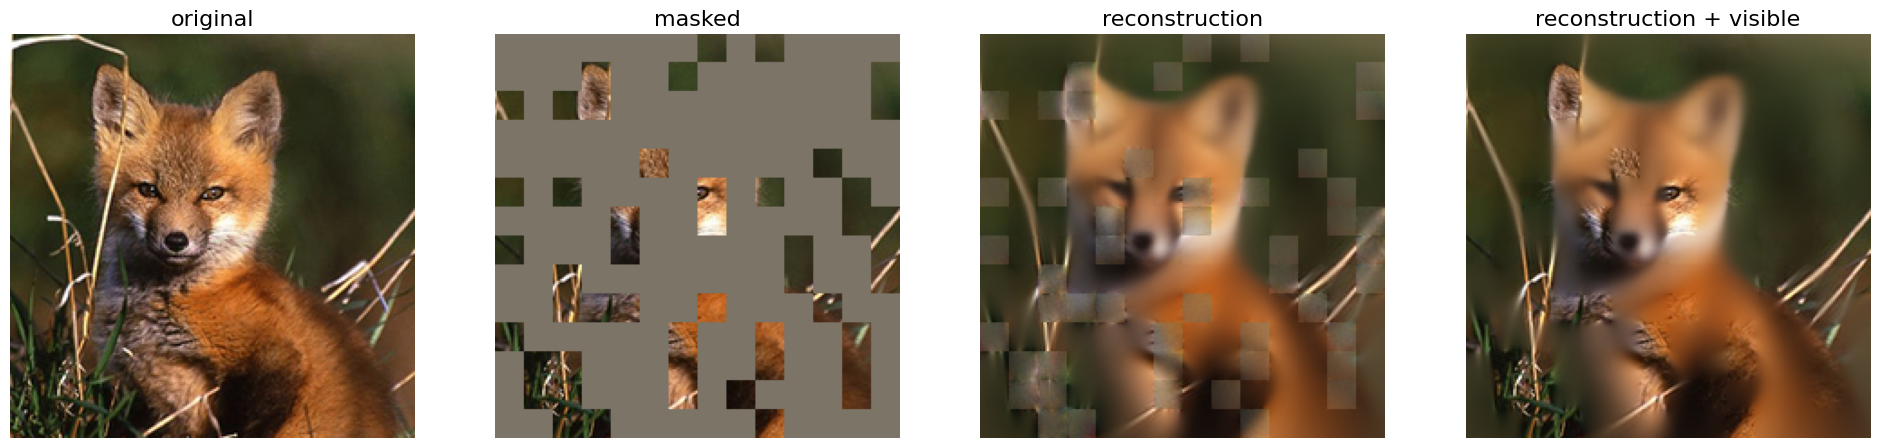

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [8]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


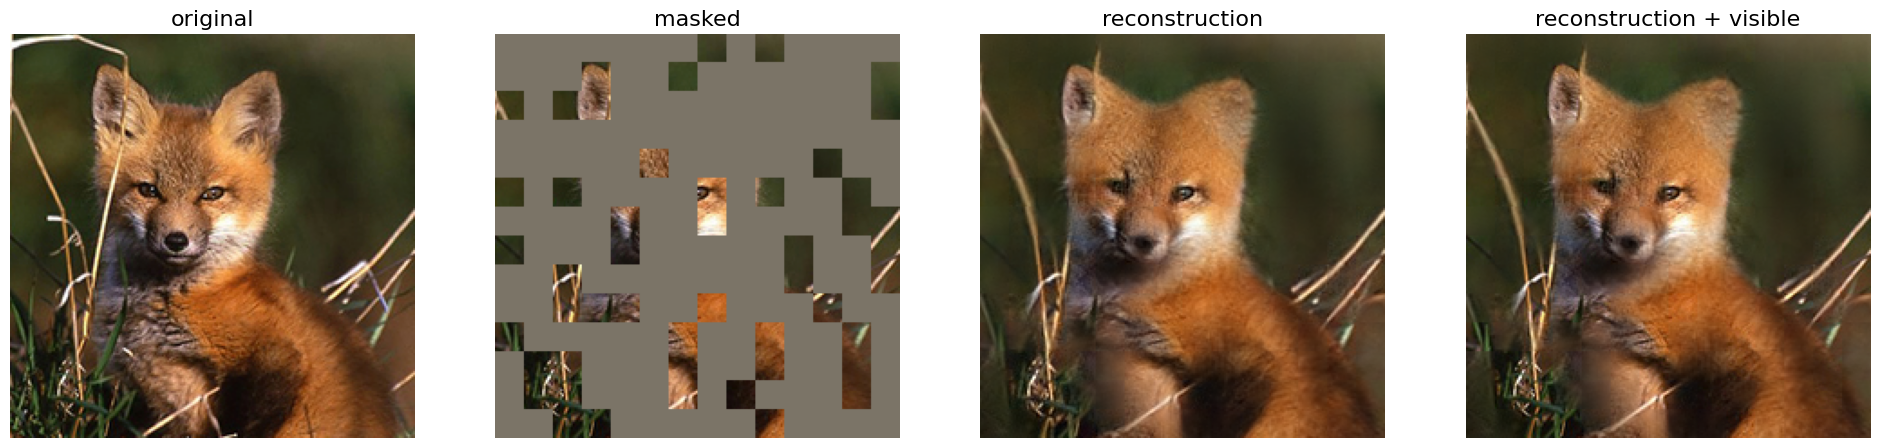

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

### Pretrain on ImageNet - small experiment

In [20]:
# job_dir='/Users/dpeleg/PycharmProjects/mae'
# nodes=1 # 8
# use_volta32=True
# batch_size=64
# model='mae_vit_large_patch16' # mae_vit_huge_patch14
# norm_pix_loss=True
# mask_ratio=0.75
# epochs=20 # 800
# warmup_epochs=5 # 40
# blr=1.5e-4
# weight_decay=0.05
# data_path='/Users/dpeleg/local/imagenet1k'

import argparse
# Create a Namespace object with your arguments
args = argparse.Namespace(
    job_dir='/Users/dpeleg/PycharmProjects/mae',
    nodes=1,
    ngpus=1,
    use_volta32=True,
    batch_size=64,
    model='mae_vit_large_patch16',
    norm_pix_loss=True,
    mask_ratio=0.75,
    epochs=20,
    warmup_epochs=5,
    blr=1.5e-4,
    weight_decay=0.05,
    data_path='/Users/dpeleg/local/imagenet1k',
    timeout=12,
    arg1="value1", arg2="value2")


from pathlib import Path

import main_pretrain as trainer
import submitit

In [21]:
def get_shared_folder() -> Path:
    user = os.getenv("USER")
    if Path("/checkpoint/").is_dir():
        p = Path(f"/checkpoint/{user}/experiments")
        p.mkdir(exist_ok=True)
        return p
    raise RuntimeError("No shared folder available")


def get_init_file():
    # Init file must not exist, but it's parent dir must exist.
    os.makedirs(str(get_shared_folder()), exist_ok=True)
    init_file = get_shared_folder() / f"{uuid.uuid4().hex}_init"
    if init_file.exists():
        os.remove(str(init_file))
    return init_file


class Trainer(object):
    def __init__(self, args):
        self.args = args

    def __call__(self):
        import main_pretrain as trainer

        self._setup_gpu_args()
        trainer.main(self.args)

    def checkpoint(self):
        import os
        import submitit

        self.args.dist_url = get_init_file().as_uri()
        checkpoint_file = os.path.join(self.args.output_dir, "checkpoint.pth")
        if os.path.exists(checkpoint_file):
            self.args.resume = checkpoint_file
        print("Requeuing ", self.args)
        empty_trainer = type(self)(self.args)
        return submitit.helpers.DelayedSubmission(empty_trainer)

    def _setup_gpu_args(self):
        import submitit
        from pathlib import Path

        job_env = submitit.JobEnvironment()
        self.args.output_dir = Path(str(self.args.output_dir).replace("%j", str(job_env.job_id)))
        self.args.log_dir = self.args.output_dir
        self.args.gpu = job_env.local_rank
        self.args.rank = job_env.global_rank
        self.args.world_size = job_env.num_tasks
        print(f"Process group: {job_env.num_tasks} tasks, rank: {job_env.global_rank}")

In [ ]:
# Note that the folder will depend on the job_id, to easily track experiments
executor = submitit.AutoExecutor(folder=job_dir, slurm_max_num_timeout=30)

num_gpus_per_node = args.ngpus
nodes = args.nodes
timeout_min = args.timeout

partition = args.partition
kwargs = {}
if args.use_volta32:
    kwargs['slurm_constraint'] = 'volta32gb'
if args.comment:
    kwargs['slurm_comment'] = args.comment

executor.update_parameters(
    mem_gb=40 * num_gpus_per_node,
    gpus_per_node=num_gpus_per_node,
    tasks_per_node=num_gpus_per_node,  # one task per GPU
    cpus_per_task=10,
    nodes=nodes,
    timeout_min=timeout_min,  # max is 60 * 72
    # Below are cluster dependent parameters
    slurm_partition=partition,
    slurm_signal_delay_s=120,
    **kwargs
)

executor.update_parameters(name="mae")

args.dist_url = get_init_file().as_uri()
args.output_dir = args.job_dir

trainer = Trainer(args)
job = executor.submit(trainer)

# print("Submitted job_id:", job.job_id)
print(job.job_id)

